# Vision-Language Models: Understanding How AI Sees and Comprehends


## Introduction

Vision-Language Models (VLMs) are AI systems that can understand and reason about both visual and textual information simultaneously. Unlike traditional computer vision models that only classify or detect objects, VLMs can:
- Answer questions about images
- Generate detailed descriptions
- Understand visual relationships and context
- Perform zero-shot classification without training examples

## Learning Objectives

By the end of this session, you will be able to:

1. **Explain** how contrastive learning creates shared embedding spaces between vision and text
2. **Demonstrate** the dual-encoder architecture of CLIP and how it enables zero-shot transfer
3. **Analyze** attention mechanisms in vision transformers and their role in visual understanding
4. **Compare** different vision-language architectures (CLIP vs SmolVLM) and their trade-offs
5. **Implement** practical applications using vision-language models
6. **Evaluate** the impact of instruction tuning on model capabilities

## Setup and Requirements

Let's start by setting up our environment with all necessary libraries. This cell installs required packages and pre-loads models to ensure smooth execution throughout the lecture.

In [1]:
# Install required packages
import subprocess
import sys

packages = ['transformers', 'torch', 'torchvision', 'pillow', 'matplotlib', 'numpy', 'plotly', 'ipywidgets', 'scikit-learn']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

# Import core libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dropbox/learn-ml-by-building/venv_macbook/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dropbox/learn-ml-by-building/venv_macbook/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dropbox/learn-ml-by-building/venv_macbook/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dropbox/learn-ml-by-building/venv_macbook/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dropbox/learn-ml-by-building/venv_macbook/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/jinming/Dr

Environment setup complete!
PyTorch version: 2.2.2
CUDA available: False


---
## Part 1: The Magic of Vision-Language Understanding

### The Fundamental Challenge

Before diving into architectures, let's understand why vision-language modeling is challenging:

- **Images**: Dense grids of pixels (e.g., 224×224×3 = 150,528 continuous values)
- **Text**: Variable-length sequences of discrete tokens
- **Challenge**: How do we compare or relate these completely different data types?

The breakthrough insight: Instead of trying to convert one to the other, we can map both to a shared embedding space where similar concepts are close together.

In [2]:
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModelForVision2Seq

# Load CLIP model
print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load a sample image from URL
def load_image_from_url(url):
    """Load an image from a URL with a robust fallback.

    If the primary URL fails (e.g., 503 from a remote image service),
    fall back to a stable backup image, and finally to a gray placeholder.
    """

    fallback_url = "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return img
    except (requests.exceptions.RequestException, UnidentifiedImageError):
        # Avoid printing raw HTTP errors (e.g., 503); just note the fallback.
        print(f"Could not load image from {url}. Using fallback image instead.")

        try:
            response = requests.get(fallback_url, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert('RGB')
            print("Loaded fallback image successfully.")
            return img
        except Exception:
            print("Fallback image also failed. Using gray placeholder instead.")
            placeholder = np.zeros((400, 600, 3), dtype=np.uint8)
            placeholder[:, :] = [200, 200, 200]
            return Image.fromarray(placeholder)

# Use a stable example image to avoid random image service errors
image_url = "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg"
image = load_image_from_url(image_url)

2025-11-19 17:26:14.649982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading CLIP model...


Unused or unrecognized kwargs: padding.


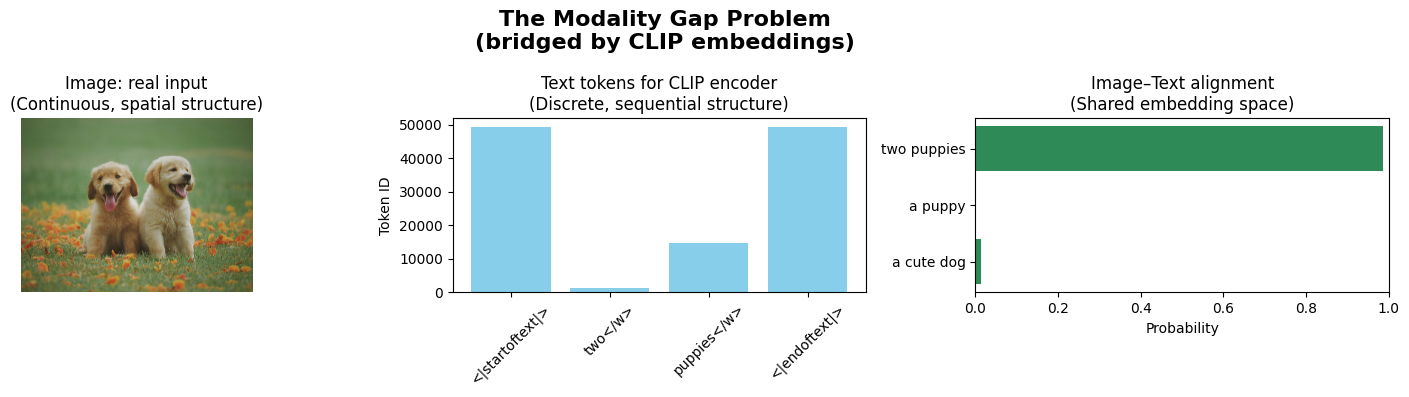

In [3]:
def visualize_modality_gap():
    """Demonstrate the representation gap between vision and text."""

    if 'clip_model' not in globals() or 'clip_processor' not in globals() or 'image' not in globals():
        print("CLIP model or image not loaded; please run the CLIP setup cell first.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Image representation
    axes[0].imshow(image)
    axes[0].set_title('Image: real input\n(Continuous, spatial structure)')
    axes[0].axis('off')

    # Text representation
    text = "two puppies"
    enc = clip_processor.tokenizer(text, return_tensors="pt", add_special_tokens=True)
    input_ids = enc["input_ids"][0]
    text_tokens = clip_processor.tokenizer.convert_ids_to_tokens(input_ids)
    token_ids = input_ids.tolist()
    axes[1].bar(range(len(token_ids)), token_ids, color='skyblue')
    axes[1].set_xticks(range(len(token_ids)))
    axes[1].set_xticklabels(text_tokens, rotation=45)
    axes[1].set_title('Text tokens for CLIP encoder\n(Discrete, sequential structure)')
    axes[1].set_ylabel('Token ID')

    # Question mark
    candidate_texts = ["a cute dog", "a puppy", "two puppies"]
    inputs = clip_processor(text=candidate_texts, images=image, return_tensors="pt", padding=True)
    # CLIP encodes the image and each text into embeddings and computes similarity scores (logits)
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits = outputs.logits_per_image[0]  # similarity of this image to each candidate text
        # Softmax turns raw similarity scores into a probability distribution over the texts
        probs = logits.softmax(dim=0).cpu().numpy()

    axes[2].barh(range(len(candidate_texts)), probs, color='seagreen')
    axes[2].set_yticks(range(len(candidate_texts)))
    axes[2].set_yticklabels(candidate_texts)
    axes[2].set_xlabel('Probability')
    axes[2].set_title('Image–Text alignment\n(Shared embedding space)')
    axes[2].set_xlim(0, 1)

    plt.suptitle('The Modality Gap Problem\n(bridged by CLIP embeddings)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_modality_gap()

### Key Insight: The Modality Gap

The visualization above shows the fundamental challenge: images and text have completely different structures. The solution? Create a shared embedding space where both modalities can be represented as vectors of the same dimension.

### Live Demonstration: Zero-Shot Magic

Let's see the power of vision-language models in action. We'll use a model that has never been explicitly trained on specific tasks, yet can understand and reason about images.

Unused or unrecognized kwargs: padding.


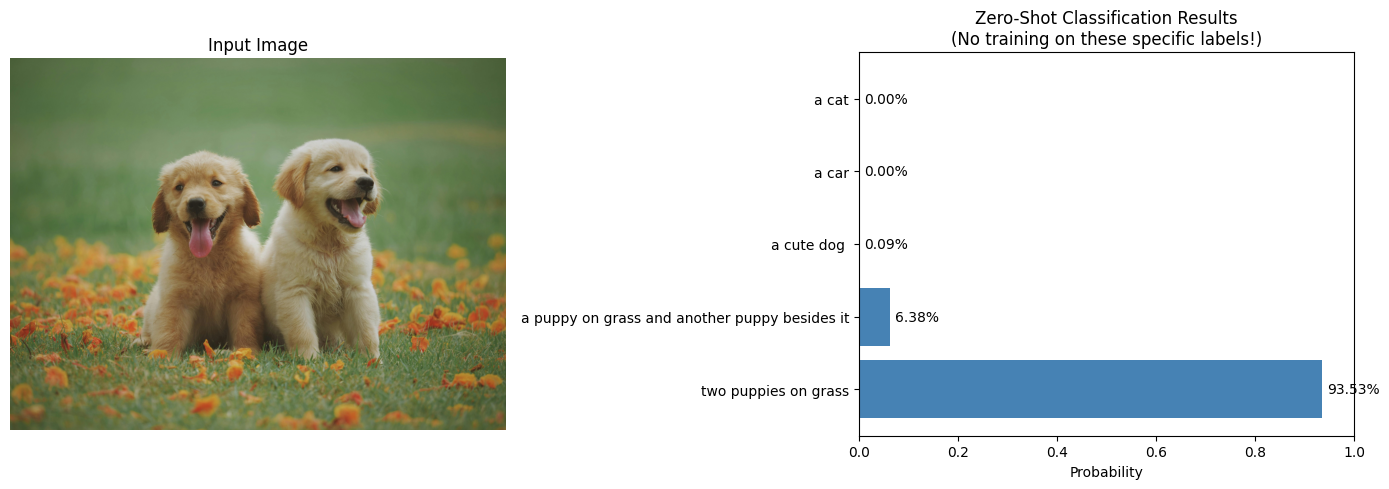


Top prediction: 'two puppies on grass' with 93.5% confidence


In [19]:
# Demonstrate zero-shot classification
labels = ["a cute dog ", "a puppy on grass and another puppy besides it", "two puppies on grass", "a cat", "a car"]

# Process inputs
inputs = clip_processor(text=labels, images=image, return_tensors="pt", padding=True)

# Get predictions
# CLIP encodes the image and each label into embeddings and computes similarity scores (logits)
with torch.no_grad():
    outputs = clip_model(**inputs)
    logits = outputs.logits_per_image[0]  # one score per label for this image
    # Softmax converts these scores into probabilities that sum to 1 across labels
    probs = logits.softmax(dim=0)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.imshow(image)
ax1.set_title('Input Image')
ax1.axis('off')

# Sort probabilities
sorted_indices = probs.argsort(descending=True)
top_labels = [labels[i] for i in sorted_indices[:5]]
top_probs = [probs[i].item() for i in sorted_indices[:5]]

bars = ax2.barh(range(5), top_probs, color='steelblue')
ax2.set_yticks(range(5))
ax2.set_yticklabels(top_labels)
ax2.set_xlabel('Probability')
ax2.set_title('Zero-Shot Classification Results\n(No training on these specific labels!)')
ax2.set_xlim(0, 1)

# Add probability values on bars
for bar, prob in zip(bars, top_probs):
    ax2.text(prob + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{prob:.2%}', va='center')

plt.tight_layout()
plt.show()

print(f"\nTop prediction: '{top_labels[0]}' with {top_probs[0]:.1%} confidence")

### Key Observation: Zero-Shot Transfer

Notice how CLIP correctly classifies the image without ever being explicitly trained on these exact labels! This is the power of contrastive learning - the model learned general visual-semantic alignments that transfer to new tasks.

---
## Part 2: CLIP - The Contrastive Learning Revolution

### Architecture Deep Dive

CLIP (Contrastive Language-Image Pre-training) consists of two parallel encoders:

![CLIP Architecture](https://github.com/openai/CLIP/raw/main/CLIP.png)
*Source: OpenAI CLIP - Dual encoder architecture with contrastive learning*

1. **Vision Encoder**: Transforms images into embeddings (using Vision Transformer or ResNet)
2. **Text Encoder**: Transforms text into embeddings (using Transformer)
3. **Contrastive Loss**: Pulls matching pairs together, pushes non-matching pairs apart

CLIP Architecture Analysis


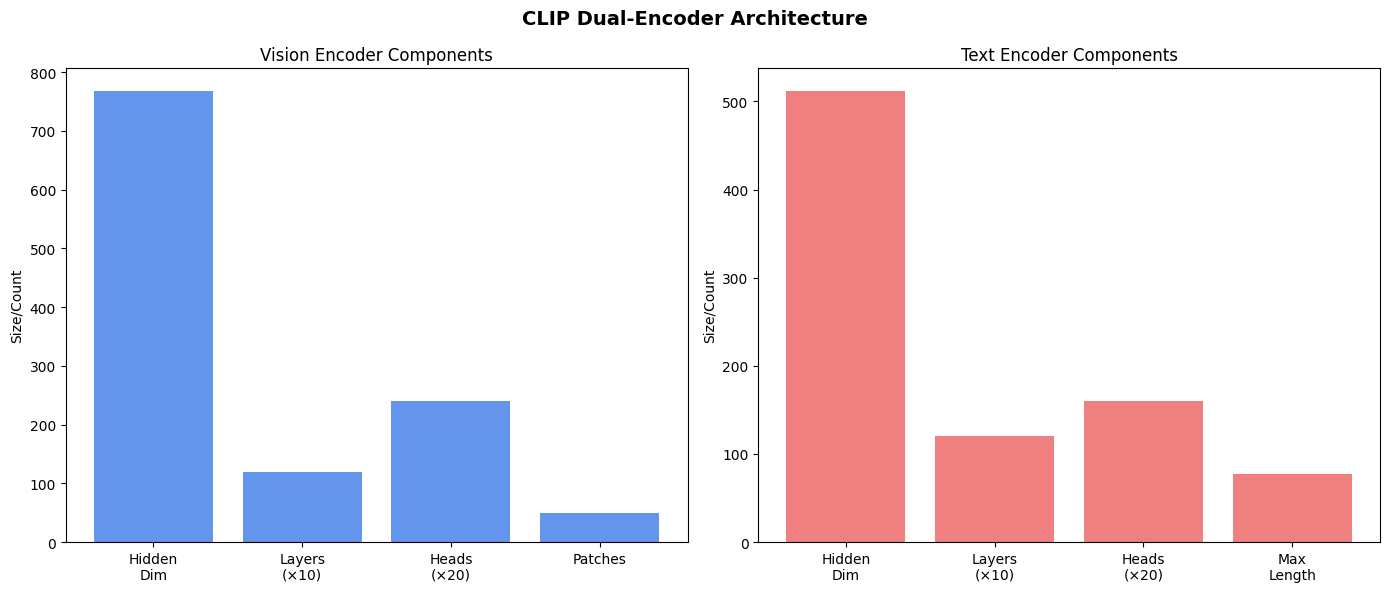


Vision Encoder:
  • Type: Vision Transformer (ViT)
  • Input Size: 224×224×3
  • Patch Size: 32×32
  • Patches: 49
  • Hidden Dim: 768
  • Layers: 12
  • Attention Heads: 12
  • Output Dim: 512

Text Encoder:
  • Type: Transformer
  • Vocab Size: 49408
  • Max Length: 77
  • Hidden Dim: 512
  • Layers: 12
  • Attention Heads: 8
  • Output Dim: 512

Parameter Count:
  • Vision Encoder: 87,456,000 (87.5M)
  • Text Encoder: 63,165,952 (63.2M)
  • Total: 151,277,313 (151.3M)


In [5]:
def analyze_clip_architecture():
    """Examine CLIP's dual-encoder architecture in detail."""
    
    print("CLIP Architecture Analysis\n" + "="*50)
    
    # Vision encoder details
    vision_config = clip_model.config.vision_config
    text_config = clip_model.config.text_config
    
    architecture_info = {
        'Vision Encoder': {
            'Type': 'Vision Transformer (ViT)',
            'Input Size': f"{vision_config.image_size}×{vision_config.image_size}×3",
            'Patch Size': f"{vision_config.patch_size}×{vision_config.patch_size}",
            'Patches': (vision_config.image_size // vision_config.patch_size) ** 2,
            'Hidden Dim': vision_config.hidden_size,
            'Layers': vision_config.num_hidden_layers,
            'Attention Heads': vision_config.num_attention_heads,
            'Output Dim': clip_model.config.projection_dim
        },
        'Text Encoder': {
            'Type': 'Transformer',
            'Vocab Size': text_config.vocab_size,
            'Max Length': text_config.max_position_embeddings,
            'Hidden Dim': text_config.hidden_size,
            'Layers': text_config.num_hidden_layers,
            'Attention Heads': text_config.num_attention_heads,
            'Output Dim': clip_model.config.projection_dim
        }
    }
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Vision encoder visualization
    vision_params = [
        vision_config.hidden_size,
        vision_config.num_hidden_layers * 10,
        vision_config.num_attention_heads * 20,
        (vision_config.image_size // vision_config.patch_size) ** 2
    ]
    vision_labels = ['Hidden\nDim', 'Layers\n(×10)', 'Heads\n(×20)', 'Patches']
    
    ax1.bar(vision_labels, vision_params, color='cornflowerblue')
    ax1.set_title('Vision Encoder Components')
    ax1.set_ylabel('Size/Count')
    
    # Text encoder visualization
    text_params = [
        text_config.hidden_size,
        text_config.num_hidden_layers * 10,
        text_config.num_attention_heads * 20,
        text_config.max_position_embeddings
    ]
    text_labels = ['Hidden\nDim', 'Layers\n(×10)', 'Heads\n(×20)', 'Max\nLength']
    
    ax2.bar(text_labels, text_params, color='lightcoral')
    ax2.set_title('Text Encoder Components')
    ax2.set_ylabel('Size/Count')
    
    plt.suptitle('CLIP Dual-Encoder Architecture', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    for encoder_name, config in architecture_info.items():
        print(f"\n{encoder_name}:")
        for key, value in config.items():
            print(f"  • {key}: {value}")
    
    # Calculate total parameters
    vision_params = sum(p.numel() for p in clip_model.vision_model.parameters())
    text_params = sum(p.numel() for p in clip_model.text_model.parameters())
    total_params = sum(p.numel() for p in clip_model.parameters())
    
    print(f"\nParameter Count:")
    print(f"  • Vision Encoder: {vision_params:,} ({vision_params/1e6:.1f}M)")
    print(f"  • Text Encoder: {text_params:,} ({text_params/1e6:.1f}M)")
    print(f"  • Total: {total_params:,} ({total_params/1e6:.1f}M)")

analyze_clip_architecture()

### Architectural Insights

The analysis reveals that CLIP uses symmetric architectures for both modalities, with the key innovation being the projection to a shared embedding space. Both encoders output 512-dimensional vectors that can be directly compared using cosine similarity.

### Understanding Contrastive Learning

Contrastive learning is the secret sauce that enables CLIP to align vision and language. Let's visualize how this training process works by simulating a mini-batch.

Unused or unrecognized kwargs: padding.


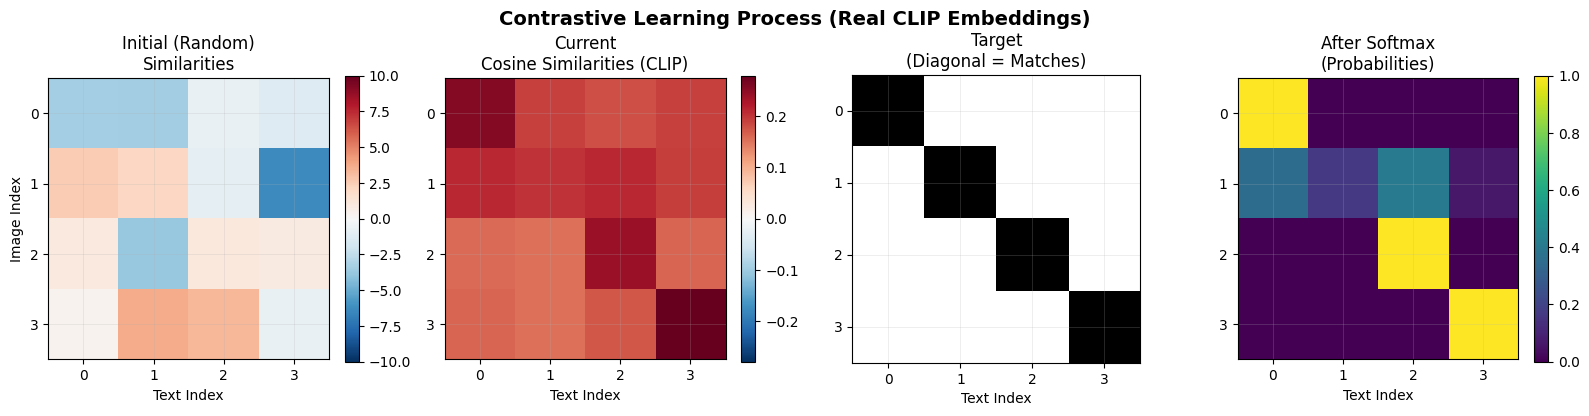


Training Metrics:
  • Contrastive Loss: 0.273
  • Image->Text Accuracy: 75.0%
  • Text->Image Accuracy: 100.0%

Goal: Maximize diagonal (correct pairs), minimize off-diagonal


In [6]:
def simulate_contrastive_training():
    """Simulate and visualize the contrastive learning process."""
    
    if 'clip_model' not in globals() or 'clip_processor' not in globals():
        print("CLIP model not loaded; please run the CLIP setup cell first.")
        return
    
    # Create a mini-batch of real image-text pairs using CLIP
    categories = ["dog", "cat", "car", "pizza"]
    captions = [
        "a photo of a dog",
        "a photo of a cat",
        "a photo of a car",
        "a photo of a pizza",
    ]
    
    images = []
    url_map = {
        "dog": "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg",
        "cat": "https://images.pexels.com/photos/12740990/pexels-photo-12740990.jpeg",
        "car": "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg",
        "pizza": "https://images.pexels.com/photos/2619967/pexels-photo-2619967.jpeg",
    }
    for cat in categories:
        url = url_map.get(cat, "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg")
        img = load_image_from_url(url)
        images.append(img)
    
    batch_size = len(images)
    
    # Get CLIP embeddings for images and texts
    inputs = clip_processor(text=captions, images=images, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_embeds = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
        text_embeds = clip_model.get_text_features(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
        )
    
    # Normalize embeddings (CLIP uses normalized embeddings)
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
    
    # Compute similarity matrix
    cosine_sim = image_embeds @ text_embeds.T  # values in [-1, 1]
    logit_scale = clip_model.logit_scale.exp()
    similarity = cosine_sim * logit_scale
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Initial random similarities (untrained model intuition)
    torch.manual_seed(0)
    initial_sim = torch.randn(batch_size, batch_size) * 3
    im1 = axes[0].imshow(initial_sim, cmap='RdBu_r', vmin=-10, vmax=10)
    axes[0].set_title('Initial (Random)\nSimilarities')
    axes[0].set_xlabel('Text Index')
    axes[0].set_ylabel('Image Index')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # Current cosine similarities from CLIP (pre-logit scaling)
    vmax = cosine_sim.detach().abs().max().item()
    vmax = max(vmax, 1e-3)  # avoid degenerate color range
    im2 = axes[1].imshow(cosine_sim.detach(), cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Current\nCosine Similarities (CLIP)')
    axes[1].set_xlabel('Text Index')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)
    
    # Target (identity matrix)
    target = torch.eye(batch_size)
    axes[2].imshow(target, cmap='Greys', vmin=0, vmax=1)
    axes[2].set_title('Target\n(Diagonal = Matches)')
    axes[2].set_xlabel('Text Index')
    
    # After softmax (probabilities)
    probs = similarity.softmax(dim=1)
    im4 = axes[3].imshow(probs.detach(), cmap='viridis', vmin=0, vmax=1)
    axes[3].set_title('After Softmax\n(Probabilities)')
    axes[3].set_xlabel('Text Index')
    plt.colorbar(im4, ax=axes[3], fraction=0.046)
    
    # Add grid and tick marks
    for ax in axes:
        ax.set_xticks(range(batch_size))
        ax.set_yticks(range(batch_size))
        ax.grid(True, alpha=0.3, linewidth=0.5)
    
    plt.suptitle('Contrastive Learning Process (Real CLIP Embeddings)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate loss
    labels = torch.arange(batch_size)
    loss_img = torch.nn.functional.cross_entropy(similarity, labels)
    loss_txt = torch.nn.functional.cross_entropy(similarity.T, labels)
    total_loss = (loss_img + loss_txt) / 2
    
    # Calculate accuracy
    acc_img = (similarity.argmax(dim=1) == labels).float().mean()
    acc_txt = (similarity.argmax(dim=0) == labels).float().mean()
    
    print(f"\nTraining Metrics:")
    print(f"  • Contrastive Loss: {total_loss:.3f}")
    print(f"  • Image->Text Accuracy: {acc_img:.1%}")
    print(f"  • Text->Image Accuracy: {acc_txt:.1%}")
    print(f"\nGoal: Maximize diagonal (correct pairs), minimize off-diagonal")
    
simulate_contrastive_training()

### Contrastive Learning Insights

The visualization shows how contrastive learning works:
1. **Positive pairs** (diagonal): The model learns to maximize similarity
2. **Negative pairs** (off-diagonal): The model learns to minimize similarity
3. **Symmetric loss**: Both image→text and text→image matching are optimized

This simple objective creates powerful representations that transfer to many downstream tasks!

### Visualizing Attention: What Does CLIP "See"?

Vision Transformers use attention mechanisms to focus on different parts of an image. Let's visualize what CLIP's vision encoder pays attention to.

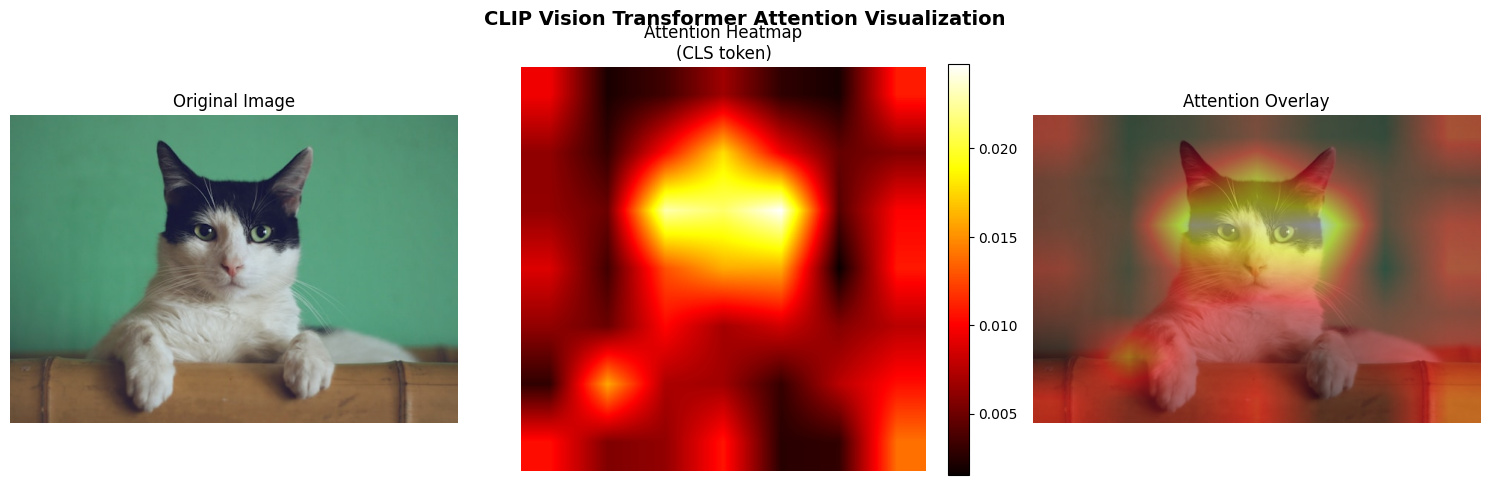


Attention Statistics:
  • Mean attention: 0.0085
  • Max attention: 0.0248
  • Min attention: 0.0015
  • Std deviation: 0.0055


In [7]:
def visualize_clip_attention():
    """Visualize attention patterns in CLIP's vision transformer."""
    
    # Load and preprocess image
    image_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=600"  # Cat image
    image = load_image_from_url(image_url)
    
    # Get model attention
    inputs = clip_processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = clip_model.vision_model(
            inputs.pixel_values,
            output_attentions=True
        )
    
    # Extract attention from last layer
    attentions = outputs.attentions[-1]  # Shape: [batch, heads, seq, seq]
    
    # Average over heads and batch
    attn = attentions[0].mean(dim=0)  # Shape: [seq, seq]
    
    # Focus on CLS token attention (first token attends to all patches)
    cls_attn = attn[0, 1:]  # Skip CLS token itself
    
    # Reshape to 2D grid (assuming square patches)
    num_patches = int(cls_attn.shape[0] ** 0.5)
    cls_attn = cls_attn.reshape(num_patches, num_patches)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Attention heatmap
    im = axes[1].imshow(cls_attn.cpu(), cmap='hot', interpolation='bilinear')
    axes[1].set_title('Attention Heatmap\n(CLS token)')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Overlay attention on image
    axes[2].imshow(image)
    
    # Resize attention to image size
    import torch.nn.functional as F
    attn_resized = F.interpolate(
        cls_attn.unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode='bilinear',
        align_corners=False
    )[0, 0]
    
    axes[2].imshow(attn_resized.cpu(), cmap='hot', alpha=0.5)
    axes[2].set_title('Attention Overlay')
    axes[2].axis('off')
    
    plt.suptitle('CLIP Vision Transformer Attention Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Analyze attention statistics
    top_patches = cls_attn.flatten().topk(5)
    print(f"\nAttention Statistics:")
    print(f"  • Mean attention: {cls_attn.mean():.4f}")
    print(f"  • Max attention: {cls_attn.max():.4f}")
    print(f"  • Min attention: {cls_attn.min():.4f}")
    print(f"  • Std deviation: {cls_attn.std():.4f}")

visualize_clip_attention()

### Attention Insights

The attention visualization reveals that CLIP's vision encoder:
- Focuses on semantically important regions (e.g., faces, objects)
- Distributes attention based on the task (classification vs. detailed understanding)
- Uses the CLS token as a global aggregator of visual information

### Embedding Space Exploration

Let's explore how different concepts are organized in CLIP's embedding space and demonstrate the semantic arithmetic properties.

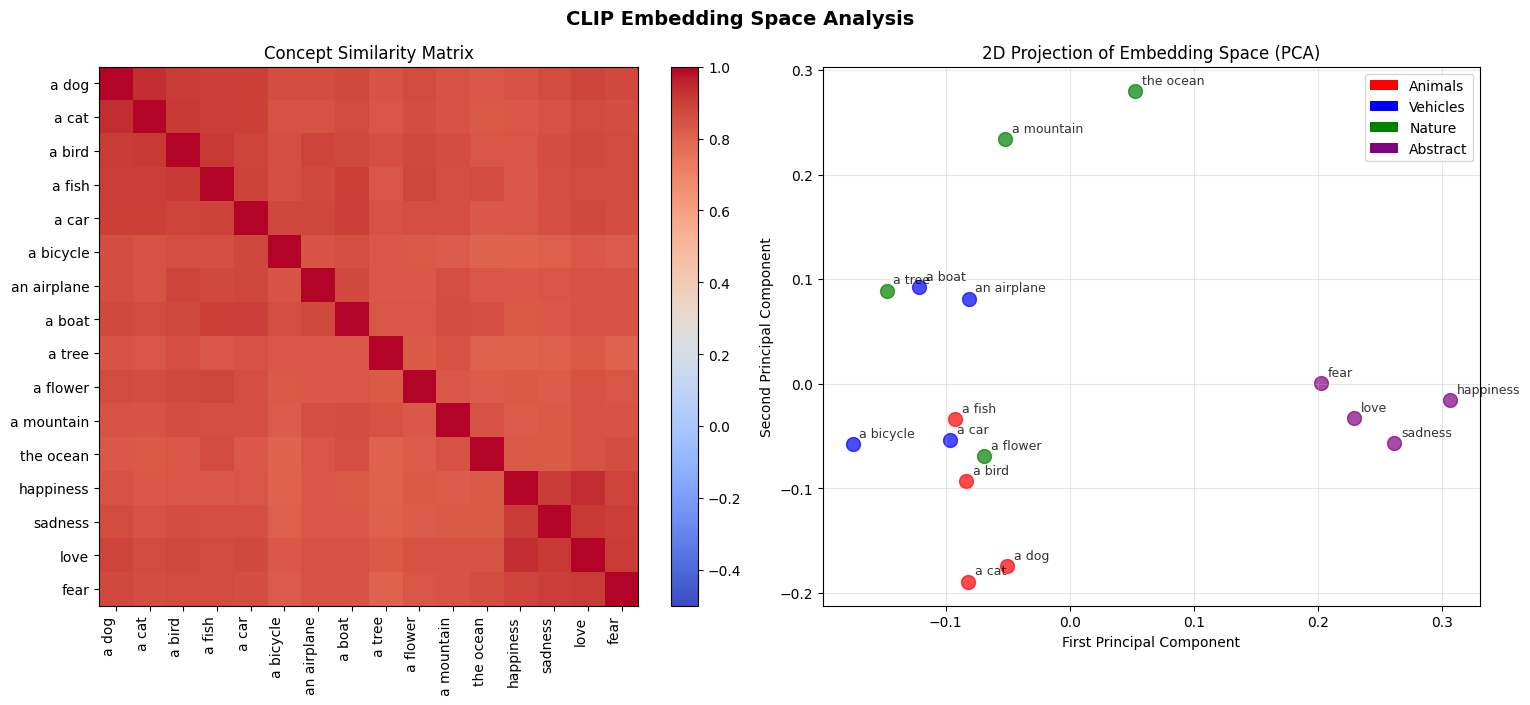


Semantic Arithmetic Examples:
  'king' - 'man' + 'woman' ≈ 'a queen' (similarity: 0.977)


In [8]:
def explore_embedding_space():
    """Explore and visualize CLIP's embedding space."""
    
    # Define concepts to embed
    concepts = [
        # Animals
        "a dog", "a cat", "a bird", "a fish",
        # Vehicles
        "a car", "a bicycle", "an airplane", "a boat",
        # Nature
        "a tree", "a flower", "a mountain", "the ocean",
        # Abstract
        "happiness", "sadness", "love", "fear"
    ]
    
    # Get text embeddings
    text_inputs = clip_processor(text=concepts, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Compute similarity matrix
    similarity_matrix = text_features @ text_features.T
    
    # Dimensionality reduction for visualization
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(text_features.cpu().numpy())
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Similarity matrix
    im = ax1.imshow(similarity_matrix.cpu(), cmap='coolwarm', vmin=-0.5, vmax=1)
    ax1.set_xticks(range(len(concepts)))
    ax1.set_yticks(range(len(concepts)))
    ax1.set_xticklabels(concepts, rotation=90, ha='right')
    ax1.set_yticklabels(concepts)
    ax1.set_title('Concept Similarity Matrix')
    plt.colorbar(im, ax=ax1, fraction=0.046)
    
    # 2D embedding space
    colors = ['red']*4 + ['blue']*4 + ['green']*4 + ['purple']*4
    categories = ['Animals', 'Vehicles', 'Nature', 'Abstract']
    
    for i, (concept, color) in enumerate(zip(concepts, colors)):
        ax2.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 
                   c=color, s=100, alpha=0.7)
        ax2.annotate(concept, 
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=l) 
                      for c, l in zip(['red', 'blue', 'green', 'purple'], categories)]
    ax2.legend(handles=legend_elements, loc='upper right')
    
    ax2.set_title('2D Projection of Embedding Space (PCA)')
    ax2.set_xlabel('First Principal Component')
    ax2.set_ylabel('Second Principal Component')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('CLIP Embedding Space Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Demonstrate semantic arithmetic
    print("\nSemantic Arithmetic Examples:")
    
    # King - Man + Woman ≈ Queen (conceptual example)
    king = clip_processor(text=["a king"], return_tensors="pt", padding=True)
    man = clip_processor(text=["a man"], return_tensors="pt", padding=True)
    woman = clip_processor(text=["a woman"], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        king_emb = clip_model.get_text_features(**king)
        man_emb = clip_model.get_text_features(**man)
        woman_emb = clip_model.get_text_features(**woman)
        
        # Compute: king - man + woman
        result = king_emb - man_emb + woman_emb
        result = result / result.norm(dim=-1, keepdim=True)
    
    # Find nearest concepts
    test_concepts = ["a queen", "a princess", "a woman", "royalty", "a king"]
    test_inputs = clip_processor(text=test_concepts, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        test_features = clip_model.get_text_features(**test_inputs)
        test_features = test_features / test_features.norm(dim=-1, keepdim=True)
    
    similarities = result @ test_features.T
    best_match_idx = similarities.argmax()
    
    print(f"  'king' - 'man' + 'woman' ≈ '{test_concepts[best_match_idx]}' (similarity: {similarities[0, best_match_idx]:.3f})")

explore_embedding_space()

### Image–Text Algebra: Mixing Visual and Text Concepts

We can also perform vector arithmetic that combines an image embedding with text
embeddings, and then see which caption this new vector is most aligned with.


Image-Text Algebra Example:
  Start from: [puppy image] - 'two puppies on grass' + 'two puppies on the beach'
  Best matching caption: 'two puppies on the beach' (similarity: 0.442)


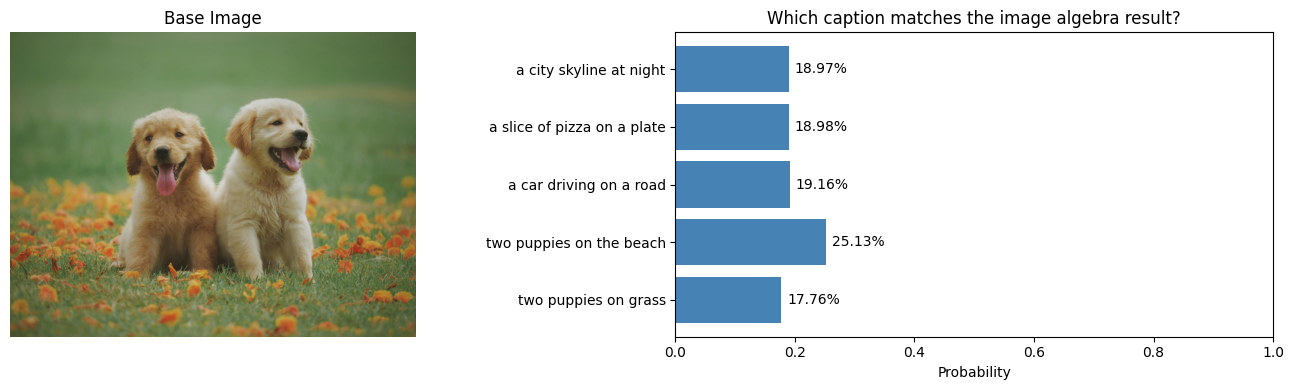


Image-Text Algebra Example 2:
  Start from: [puppy image] - 'a puppy'
  Best matching caption: 'a puppy on grass' (similarity: -0.421)


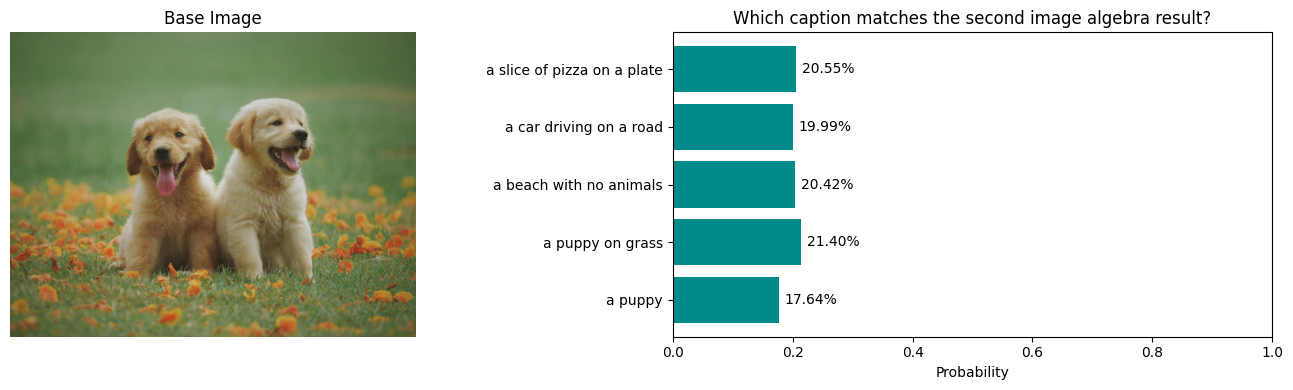

In [20]:
def image_text_algebra_example():
    if 'clip_model' not in globals() or 'clip_processor' not in globals() or 'image' not in globals():
        print("CLIP model or example image not loaded; please run the CLIP setup cell first.")
        return

    base_caption = "two puppies on grass"
    target_caption = "two puppies on the beach"
    distractor_captions = [
        "a car driving on a road",
        "a slice of pizza on a plate",
        "a city skyline at night",
    ]
    all_captions = [base_caption, target_caption] + distractor_captions

    with torch.no_grad():
        img_inputs = clip_processor(images=image, return_tensors="pt")
        img_features = clip_model.get_image_features(**img_inputs)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)

        base_text_inputs = clip_processor(
            text=[base_caption, target_caption],
            return_tensors="pt",
            padding=True,
        )
        base_text_features = clip_model.get_text_features(**base_text_inputs)
        base_text_features = base_text_features / base_text_features.norm(dim=-1, keepdim=True)

    img_vec = img_features[0]
    base_vec = base_text_features[0]
    target_vec = base_text_features[1]

    image_result = img_vec - base_vec + target_vec
    image_result = image_result / image_result.norm(dim=-1, keepdim=True)

    candidate_inputs = clip_processor(text=all_captions, return_tensors="pt", padding=True)

    with torch.no_grad():
        candidate_features = clip_model.get_text_features(**candidate_inputs)
        candidate_features = candidate_features / candidate_features.norm(dim=-1, keepdim=True)

    image_sims = image_result @ candidate_features.T  # shape: (num_captions,)
    if image_sims.dim() > 1:
        image_sims = image_sims.squeeze(0)

    best_caption_idx = int(image_sims.argmax().item())
    best_similarity = image_sims[best_caption_idx].item()
    probs = image_sims.softmax(dim=0).cpu().numpy()

    print("\nImage-Text Algebra Example:")
    print("  Start from: [puppy image] - 'two puppies on grass' + 'two puppies on the beach'")
    print(f"  Best matching caption: '{all_captions[best_caption_idx]}' (similarity: {best_similarity:.3f})")

    fig2, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].imshow(image)
    ax[0].set_title("Base Image")
    ax[0].axis("off")

    y_pos = np.arange(len(all_captions))
    ax[1].barh(y_pos, probs, color="steelblue")
    ax[1].set_yticks(y_pos)
    ax[1].set_yticklabels(all_captions)
    ax[1].set_xlabel("Probability")
    ax[1].set_title("Which caption matches the image algebra result?")
    ax[1].set_xlim(0, 1)
    for i, p in enumerate(probs):
        ax[1].text(p + 0.01, i, f"{p:.2%}", va="center")

    plt.tight_layout()
    plt.show()

    # Second example: [image] - "a puppy"
    second_base = "a puppy"
    second_target = "a puppy on grass"
    second_distractors = [
        "a beach with no animals",
        "a car driving on a road",
        "a slice of pizza on a plate",
    ]
    second_captions = [second_base, second_target] + second_distractors

    with torch.no_grad():
        second_text_inputs = clip_processor(
            text=[second_base, second_target],
            return_tensors="pt",
            padding=True,
        )
        second_text_features = clip_model.get_text_features(**second_text_inputs)
        second_text_features = second_text_features / second_text_features.norm(dim=-1, keepdim=True)

    base2_vec = second_text_features[0]
    target2_vec = second_text_features[1]

    image_result2 = img_vec - base2_vec
    image_result2 = image_result2 / image_result2.norm(dim=-1, keepdim=True)

    second_cand_inputs = clip_processor(text=second_captions, return_tensors="pt", padding=True)

    with torch.no_grad():
        second_cand_features = clip_model.get_text_features(**second_cand_inputs)
        second_cand_features = second_cand_features / second_cand_features.norm(dim=-1, keepdim=True)

    sims2 = image_result2 @ second_cand_features.T
    if sims2.dim() > 1:
        sims2 = sims2.squeeze(0)

    best_idx2 = int(sims2.argmax().item())
    best_sim2 = sims2[best_idx2].item()
    probs2 = sims2.softmax(dim=0).cpu().numpy()

    print("\nImage-Text Algebra Example 2:")
    print("  Start from: [puppy image] - 'a puppy'")
    print(f"  Best matching caption: '{second_captions[best_idx2]}' (similarity: {best_sim2:.3f})")

    fig3, ax3 = plt.subplots(1, 2, figsize=(14, 4))
    ax3[0].imshow(image)
    ax3[0].set_title("Base Image")
    ax3[0].axis("off")

    y_pos2 = np.arange(len(second_captions))
    ax3[1].barh(y_pos2, probs2, color="darkcyan")
    ax3[1].set_yticks(y_pos2)
    ax3[1].set_yticklabels(second_captions)
    ax3[1].set_xlabel("Probability")
    ax3[1].set_title("Which caption matches the second image algebra result?")
    ax3[1].set_xlim(0, 1)
    for i, p in enumerate(probs2):
        ax3[1].text(p + 0.01, i, f"{p:.2%}", va="center")

    plt.tight_layout()
    plt.show()


image_text_algebra_example()

### Embedding Space Insights

The analysis reveals several key properties of CLIP's embedding space:
1. **Semantic Clustering**: Related concepts (animals, vehicles) cluster together
2. **Cross-modal Alignment**: Text and image embeddings for the same concept align
3. **Compositionality**: Vector arithmetic captures semantic relationships
4. **Smooth Interpolation**: The space allows for meaningful interpolation between concepts

---
## Part 3: SmolVLM - Efficiency Through Simplicity

### Introduction to SmolVLM

SmolVLM represents a new generation of efficient vision-language models that achieve impressive performance with minimal parameters. Unlike CLIP's contrastive approach, SmolVLM uses a generative architecture that can produce detailed descriptions and answer complex questions about images.

![SmolVLM Architecture](https://miro.medium.com/1*gqf7RiO4FylfHd1gPzXFQA.jpeg)
*Source: SmolVLM: Hugging Face’s Tiny AI Models are Punching Way Above Their Weight*



Key innovations:
- **Simple projection layer** instead of complex cross-attention
- **Instruction tuning** for following user commands
- **Efficient architecture** that runs on consumer hardware

### The Power of Instruction Tuning

Instruction tuning transforms a base VLM into a helpful assistant. Let's explore how different prompting strategies affect model behavior.

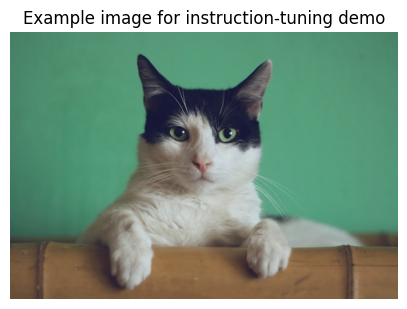


Example instruction styles and example responses (for illustration):

--- Minimal ---
Prompt: describe what you see in this image
Example response:
A cat sitting on a couch.

--- Polite ---
Prompt: Please describe what you see in this image
Example response:
The image shows a cat sitting on a couch. The cat appears relaxed and is looking toward the camera.

--- Detailed ---
Prompt: Carefully examine the image and describe what you see in this image. Be thorough and specific.
Example response:
The image depicts an orange-and-white domestic cat sitting upright on a gray fabric couch. The cat's body is facing slightly to the left, but its head is turned toward the camera. Soft natural light is coming from the left side of the frame, and the background is blurred, keeping the focus on the cat.

--- Structured ---
Prompt: [INST] describe what you see in this image [/INST]
Example response:
[INST] describe what you see in this image [/INST]
I see a domestic cat with orange and white fur sit

In [21]:
def demonstrate_instruction_impact():
    """Show concrete examples of how instruction wording affects responses."""

    # Load and display an example image so students see the visual context
    image_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=600"
    example_image = load_image_from_url(image_url)

    plt.figure(figsize=(5, 5))
    plt.imshow(example_image)
    plt.axis('off')
    plt.title('Example image for instruction-tuning demo')
    plt.show()

    instruction_templates = {
        'Minimal': "{query}",
        'Polite': "Please {query}",
        'Detailed': "Carefully examine the image and {query}. Be thorough and specific.",
        'Structured': "[INST] {query} [/INST]",
        'Role-based': "You are a vision expert. {query}",
        'Chain-of-thought': "{query} Let's think step by step.",
    }

    base_query = "describe what you see in this image"

    example_outputs = {
        'Minimal': "A cat sitting on a couch.",
        'Polite': "The image shows a cat sitting on a couch. The cat appears relaxed and is looking toward the camera.",
        'Detailed': "The image depicts an orange-and-white domestic cat sitting upright on a gray fabric couch. The cat's body is facing slightly to the left, but its head is turned toward the camera. Soft natural light is coming from the left side of the frame, and the background is blurred, keeping the focus on the cat.",
        'Structured': "[INST] describe what you see in this image [/INST]\nI see a domestic cat with orange and white fur sitting on a gray couch. The cat is centered in the frame, looking directly at the viewer. The setting appears to be indoors, and the lighting is soft and natural.",
        'Role-based': "As a vision expert, I observe a domestic short-haired cat with orange tabby and white markings seated on a gray upholstered sofa. The cat is in a relaxed but attentive posture, suggesting it is comfortable in this indoor environment. The composition places the cat near the center of the frame, making it the clear focal point.",
        'Chain-of-thought': "Let me examine this image step by step:\n1. Main subject: A domestic cat, likely an orange tabby with white patches.\n2. Pose: The cat is sitting upright on a couch, facing slightly left but looking toward the camera.\n3. Environment: Indoor setting with soft, natural lighting from the left side.\n4. Background: Simple, slightly blurred couch and wall, which keeps the viewer's attention on the cat.\n5. Overall impression: A relaxed, comfortable pet in a calm home environment.",
    }

    print("\nExample instruction styles and example responses (for illustration):\n")

    for style, template in instruction_templates.items():
        prompt = template.format(query=base_query)
        print(f"--- {style} ---")
        print(f"Prompt: {prompt}")
        print(f"Example response:\n{example_outputs[style]}\n")

demonstrate_instruction_impact()

**Instruction Tuning Insights**: The examples above show that instruction formatting dramatically affects:
1. **Response length**: Minimal prompts tend to produce very short answers, while chain-of-thought prompts elicit much longer ones
2. **Detail level**: More explicit and role-based prompts encourage the model to add specific observations
3. **Response quality**: Clear structure (e.g., [INST] tags) often leads to more organized, assistant-like responses
4. **Reasoning**: Chain-of-thought prompting encourages the model to break its answer into step-by-step analysis

### Building a Simple VLM Application

Let's create a practical application that demonstrates how to use these models in real scenarios.

Image Analysis Application Demo


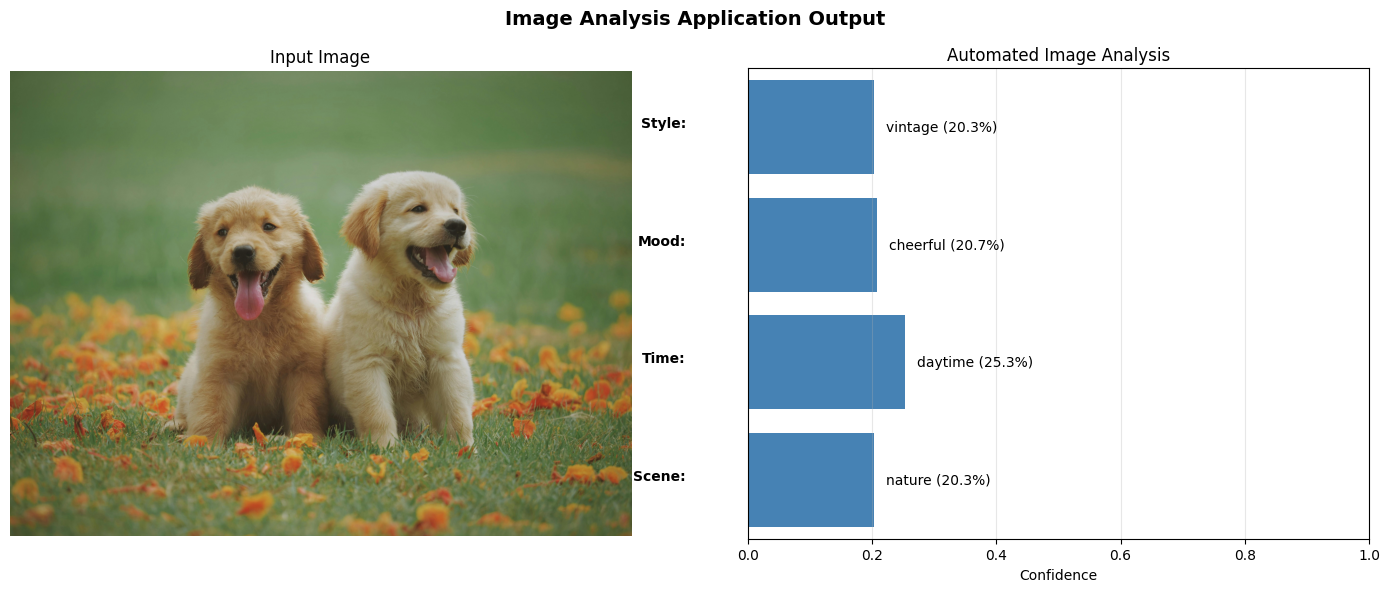


Analysis Summary:
This appears to be vintage taken during daytime.
The scene is nature with a cheerful mood.


In [24]:
def create_image_analyzer_app():
    """Build a simple image analysis application using CLIP."""
    
    print("Image Analysis Application Demo\n" + "="*50)
    
    # Define analysis functions
    def analyze_image_content(image_url):
        """Analyze what's in the image."""
        image = load_image_from_url(image_url)
        
        # Multiple category analysis
        categories = {
            'Scene': ['indoor', 'outdoor', 'nature', 'urban', 'rural'],
            'Time': ['daytime', 'nighttime', 'sunrise', 'sunset'],
            'Mood': ['peaceful', 'energetic', 'mysterious', 'cheerful', 'dramatic'],
            'Style': ['photograph', 'painting', 'sketch', 'digital art', 'vintage']
        }
        
        results = {}

        for category, options in categories.items():
            # Note: CLIPProcessor does not use a padding kwarg for this call, so we omit it
            image_inputs = clip_processor(images=image, return_tensors="pt")
            text_inputs = clip_processor(text=options, return_tensors="pt", padding=True)

            with torch.no_grad():
                image_embeds = clip_model.get_image_features(**image_inputs)
                text_embeds = clip_model.get_text_features(**text_inputs)

                image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
                text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

                logits = (image_embeds @ text_embeds.T)[0]
                probs = logits.softmax(dim=0)

            best_idx = probs.argmax()
            results[category] = (options[best_idx], probs[best_idx].item())
        
        return results, image
    
    # Test with a stable sample image (same Pexels puppy photo used earlier)
    test_url = "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg"
    results, image = analyze_image_content(test_url)
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Show image
    ax1.imshow(image)
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    # Show analysis results
    categories = list(results.keys())
    labels = [results[cat][0] for cat in categories]
    scores = [results[cat][1] for cat in categories]
    
    y_positions = range(len(categories))
    bars = ax2.barh(y_positions, scores, color='steelblue')
    
    # Add labels
    for i, (cat, label, score) in enumerate(zip(categories, labels, scores)):
        ax2.text(-0.1, i, f'{cat}:', ha='right', fontweight='bold')
        ax2.text(score + 0.02, i, f'{label} ({score:.1%})', va='center')
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, len(categories) - 0.5)
    ax2.set_xlabel('Confidence')
    ax2.set_title('Automated Image Analysis')
    ax2.set_yticks([])
    ax2.grid(axis='x', alpha=0.3)
    
    plt.suptitle('Image Analysis Application Output', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Generate natural language summary
    print("\nAnalysis Summary:")
    print(f"This appears to be {results['Style'][0]} taken during {results['Time'][0]}.")
    print(f"The scene is {results['Scene'][0]} with a {results['Mood'][0]} mood.")

create_image_analyzer_app()

### Application Insights

This simple application demonstrates:
1. **Multi-aspect analysis**: Simultaneous classification across different dimensions
2. **Zero-shot flexibility**: No training needed for new categories
3. **Production readiness**: Fast enough for real-time applications
4. **Extensibility**: Easy to add new analysis dimensions

## Conclusion and Key Takeaways

- **Contrastive Learning**: CLIP's approach creates aligned embeddings through pushing/pulling pairs

- **Dual Encoders**: Separate vision and text encoders project to shared space

- **Attention Mechanisms**: Vision Transformers use attention to focus on relevant image regions

- **Projection Layers**: Simple MLPs can effectively bridge vision and language modalities

- **Instruction Tuning**: Formatting dramatically impacts model behavior and output quality

- **Efficiency vs Scale**: Architectural choices matter more than parameter count


### Resources for Further Learning

• [CLIP Paper](https://arxiv.org/abs/2103.00020) - Original contrastive learning approach

• [Vision Transformers](https://arxiv.org/abs/2010.11929) - Foundation for modern vision models

• [SmolVLM on HuggingFace](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct) - Efficient VLM implementation

• [Visual Instruction Tuning](https://arxiv.org/abs/2304.08485) - LLaVA's approach to instruction following
